# Neutral scenarios

---

Variables to allow differentation of file names for analyses based on different calling criteria. Should be commented out when run in batch with `slurm-jupyter-run.py`

**NB:** comment out the cell below if you want to run using `slurm-jupyter-run.py`. Otherwise it will overwrite variables set by `slurm-jupyter-run.py`.

In [1]:
from nb_parameters import extract_parameter_code
exec(extract_parameter_code('nb_parameters.ipynb', '5e-05_25%'))

----

In [2]:
import re, os, sys, pickle, pickle, math
from pathlib import Path
import numpy
import numpy as np
import pandas
import pandas as pd
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# # my own libaries
# from ChromosomeWindows import window
# import genominterv

numpy.random.seed(7)

Plotting setup:

In [3]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

import mpld3

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

import random
df = DataFrame({'x': random.sample(range(1, 100), 5), 
                'y': random.sample(range(1, 100), 5),
                'z': [1,0,0,1,0],
                'k': ['male','male','male','female','female'] })

Ignore deprecation warnings from mainly seaborn:

In [4]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

### Analysis dirs

In [5]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

In [6]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [7]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

In [8]:
import time
class Timer:    
    def __enter__(self):
        self.start = time.clock()
        self.start_real = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.end_real = time.time()
        self.interval = self.end - self.start
        self.interval_real = self.end_real - self.start_real
        print("clock: {:.0f} min {:.1f} sec".format(self.interval//60, self.interval % 60))
        print("time: {:.0f} min {:.1f} sec".format(self.interval_real//60, self.interval_real % 60))

## The probability that a haplotype rise to some frequency without recombining

I use multinomial sampling to compute the number of generations until a haplotype first reaches the target frequency. In the cases where this is happens, I compute the probability that the haplotype did not recombine with other haplotypes in the meantime. Computed in `multinom_sampling.py` where parameters are also hardcoded.

In [9]:
extended_peak_regions_90 = pd.read_hdf(results_dir / f'extended_peak_regions_{ech_calling_tag}_90%.hdf')

In [10]:
!ls ../results/multi*

../results/multinom_sampling_echfreqs_10000.hdf
../results/multinom_sampling_echfreqs_15000.hdf
../results/multinom_sampling_echfreqs_20000.hdf
../results/multinom_sampling_echfreqs_25000.hdf
../results/multinom_sampling_echfreqs_5000.hdf
../results/multinom_sampling_sexavg_echfreqs_10000.hdf
../results/multinom_sampling_sexavg_echfreqs_15000.hdf
../results/multinom_sampling_sexavg_echfreqs_20000.hdf
../results/multinom_sampling_sexavg_echfreqs_25000.hdf
../results/multinom_sampling_sexavg_echfreqs_5000.hdf
../results/multinom_sampling_sexavg_spaced_10000.hdf
../results/multinom_sampling_sexavg_spaced_15000.hdf
../results/multinom_sampling_sexavg_spaced_20000.hdf
../results/multinom_sampling_sexavg_spaced_25000.hdf
../results/multinom_sampling_sexavg_spaced_5000.hdf
../results/multinom_sampling_spaced_10000.hdf
../results/multinom_sampling_spaced_15000.hdf
../results/multinom_sampling_spaced_20000.hdf
../results/multinom_sampling_spaced_25000.hdf
../results/multinom_sampling_spaced_500

In [14]:
cell_genomics = sns.plotting_context()
cell_genomics['font.size'] = 8
cell_genomics['axes.labelsize'] = 8
cell_genomics['axes.titlesize'] = 8
cell_genomics['xtick.labelsize'] = 8
cell_genomics['ytick.labelsize'] = 8
cell_genomics['legend.title_fontsize'] = 8

matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Arial"

In [15]:
spaced_df_list = []
for n in [5000, 10000, 15000, 20000, 25000]:
    spaced_df_list.append(pd.read_hdf(f'../results/multinom_sampling_sexavg_spaced_{n}.hdf'))
df = pd.concat(spaced_df_list)
df['limit_prob'] = (1/df.n_samples) * ( np.exp(-df.rec * df.length * df.max_gens) + (1 - np.exp(-df.rec * df.length * df.max_gens))/2 )
spaced_freqs = df

In [16]:
echfreq_df_list = []
for n in [5000, 10000, 15000, 20000, 25000]:
    echfreq_df_list.append(pd.read_hdf(f'../results/multinom_sampling_sexavg_echfreqs_{n}.hdf'))
df = pd.concat(echfreq_df_list)
df['limit_prob'] = (1/df.n_samples) * ( np.exp(-df.rec * df.length * df.max_gens) + (1 - np.exp(-df.rec * df.length * df.max_gens))/2 )
ech_freqs = df

In [18]:
spaced_freqs.head()

,haploid_N,freq,max_gens,rec,length,prob,tot_reached,n_samples,limit_prob
0,3900,0.05,172,7.700000e-09,500000.0,0.881529,500000,500000,0.000002
1,3900,0.10,172,7.700000e-09,500000.0,0.468987,294780,500000,0.000002
2,3900,0.15,172,7.700000e-09,500000.0,0.048444,31040,500000,0.000002
3,3900,0.20,172,7.700000e-09,500000.0,0.003810,2460,500000,0.000002
4,3900,0.25,172,7.700000e-09,500000.0,0.000218,140,500000,0.000002


In [19]:
spaced_freqs.haploid_N.unique()

array([3900, 3060, 1950, 1530])

In [20]:
ech_freqs.head()

,haploid_N,freq,max_gens,rec,length,prob,tot_reached,n_samples,limit_prob
0,3900,0.771429,172,7.700000e-09,500000.0,0.0,0,500000,0.000002
1,3900,0.785714,172,7.700000e-09,500000.0,0.0,0,500000,0.000002
2,3900,0.635714,172,7.700000e-09,500000.0,0.0,0,500000,0.000002
3,3900,0.500000,172,7.700000e-09,500000.0,0.0,0,500000,0.000002
4,3900,0.528571,172,7.700000e-09,500000.0,0.0,0,500000,0.000002


In [21]:
ech_freqs.haploid_N.unique()

array([3900, 3060, 1950, 1530])

In [22]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [23]:
spaced_freqs.max_gens.unique()

array([172, 344, 517, 689, 862])

## Probability of one ECH reaching each frequency across chromosome (showing spaced frequencies)

In [24]:
nonpar_chrX_size = ag.par2_start - ag.par1_end
nonpar_chrX_size

152231524

(same as the proportion of analysed chromosome):

In [25]:
sweep_data = pandas.read_hdf(results_dir / f'sweep_data_{ech_calling_tag}.hdf')
sweep_data.loc[sweep_data.not_missing, 'start'].unique().size * 100000
sweep_data.loc[:, 'start'].unique().size * 100000


155200000

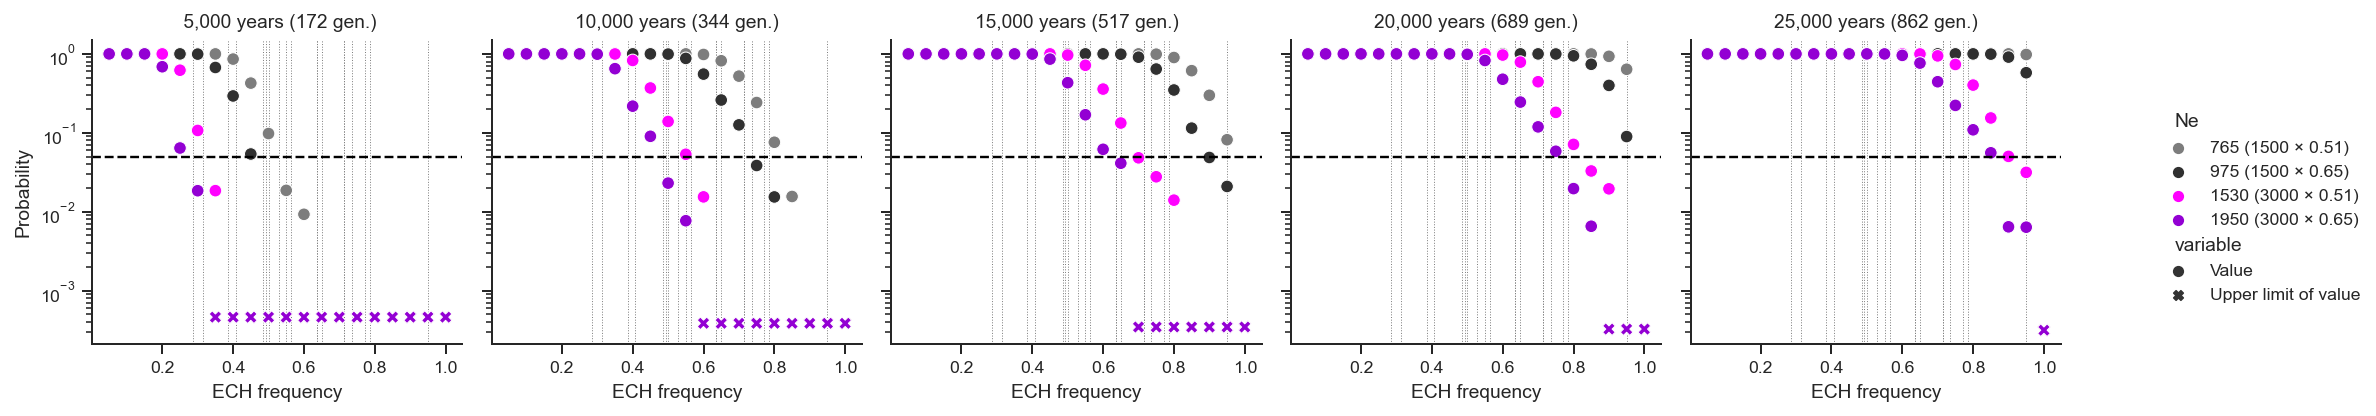

In [26]:
plot_df = spaced_freqs.copy()

plot_df['prob'] = 1 - (1 - plot_df.prob)**(nonpar_chrX_size / plot_df.length)
plot_df['limit_prob'] = 1 - (1 - plot_df.limit_prob)**(nonpar_chrX_size / plot_df.length)

plot_df.loc[plot_df['prob'] == 0, 'prob'] = np.nan
plot_df.loc[plot_df['prob'] > 0, 'limit_prob'] = np.nan
plot_df.rename(columns={'prob': 'Value', 'limit_prob': 'Upper limit of value'}, inplace=True)

plot_df.loc[plot_df['length'] == 500000.0, 'length'] = '500kb'
plot_df.loc[plot_df['length'] == 1000000.0, 'length'] = '1Mb'

plot_df = plot_df.melt(id_vars=['haploid_N', 'freq', 'max_gens', 'length', 'rec'], value_vars=['Value', 'Upper limit of value'])
plot_df['Ne'] = (plot_df.haploid_N / 2).astype('int')

# TODO INCLUDE 0.51 X/A ALSO...

plot_df = plot_df.loc[
    #(plot_df.Ne.isin([1950, 975])) & \
    # (plot_df.rec == 1.16e-8) & \
    (plot_df.rec == 0.77e-8) & \
    (plot_df.length == '500kb')]

# plot_df['Ne'] = plot_df['Ne'].cat.remove_unused_categories()
# plot_df['re'] = plot_df['Ne'].cat.remove_unused_categories()

plot_df.loc[plot_df['Ne'] == 1950, 'Ne'] = '1950 (3000 × 0.65)'
plot_df.loc[plot_df['Ne'] == 1530, 'Ne'] = '1530 (3000 × 0.51)'
plot_df.loc[plot_df['Ne'] == 975, 'Ne'] = '975 (1500 × 0.65)'
plot_df.loc[plot_df['Ne'] == 765, 'Ne'] = '765 (1500 × 0.51)'

plot_df.loc[plot_df['max_gens'] == 172, 'max_gens'] = ' 5,000 years (172 gen.)'
plot_df.loc[plot_df['max_gens'] == 344, 'max_gens'] = '10,000 years (344 gen.)'
plot_df.loc[plot_df['max_gens'] == 517, 'max_gens'] = '15,000 years (517 gen.)'
plot_df.loc[plot_df['max_gens'] == 689, 'max_gens'] = '20,000 years (689 gen.)'
plot_df.loc[plot_df['max_gens'] == 862, 'max_gens'] = '25,000 years (862 gen.)'

hue_order=['765 (1500 × 0.51)', '975 (1500 × 0.65)', '1530 (3000 × 0.51)', '1950 (3000 × 0.65)']
plot_df = plot_df.sort_values('Ne', key=np.vectorize(hue_order.index))

with sns.plotting_context('paper'):
    with sns.axes_style('ticks'):
        with sns.color_palette(["#7D7D7D", "#303030", "#FF01FF", "#9300D3"]):
        # with sns.color_palette(['tab:gray', 'tab:red']):
        
            g = sns.relplot(data=plot_df,
                            x='freq', y='value', row='rec', col='max_gens', hue='Ne',  
                            kind='scatter', style='variable', hue_order=hue_order, 
                            col_order = pd.Series(plot_df.max_gens.unique()).sort_values(), 
                              height=3, aspect=1,
#                            palette='rainbow',
                            legend="full",                            
                            facet_kws=dict(sharex=True, sharey=True, margin_titles=True),
                            s=40
                             )
#            plt.yscale('log')
            
        for ax in g.axes.flat:
            for freq in extended_peak_regions_90.prop_swept:
                ax.axvline(freq, zorder=0, color='gray', linestyle='dotted', linewidth=0.5)
            plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
            g.set_titles(row_template = '', col_template = '{col_name}')

        for ax in g.axes.flat:
            ax.set_xlabel('ECH frequency') # need to set labels manually because the names of facet function are start and end.
            ax.set_ylabel('Probability')
            plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles
            ax.axhline(0.05, linestyle="dashed", color="black")

        plt.yscale('log')
#         g.fig.subplots_adjust(top=0.9) # adjust the Figure
#         g.fig.suptitle('Global X chromosome parameters')

        plt.savefig(figures_dir / 'multinom_sims_global_cellgen_revision.pdf', bbox_inches='tight')
        plt.savefig(figures_dir / 'multinom_sims_global_cellgen_revision.png', bbox_inches='tight')

## Joint probability of all ECHs with f >= "ECH frequency" reaching the observed frequencies (showing ECH frequencies)

In [27]:
def joint_prob(df):
    df_sorted = df.copy().sort_values('freq')
    probs = [1]
    limit_probs = [1]
    for tup in df_sorted.itertuples():
        if tup.prob > 0:
            # prob = 1 - (1 - tup.prob)**(2*153)
            prob = 1 - (1 - tup.prob)**(nonpar_chrX_size / 500000)
            probs.append(prob * probs[-1])
            limit_probs.append(np.nan)
        else:
            # limit_prob = 1 - (1 - tup.limit_prob)**(2*153)
            limit_prob = 1 - (1 - tup.limit_prob)**(nonpar_chrX_size / 500000)
            limit_probs.append(limit_prob * (math.isnan(probs[-1]) and limit_probs[-1] or probs[-1]))
            probs.append(np.nan)
    df_sorted['joint_prob'] = probs[1:]
    df_sorted['limit_joint_prob'] = limit_probs[1:]

    # df_sorted['joint_prob_chromosome'] = 1 - (1 - df_sorted['joint_prob'])**153
    # df_sorted['limit_joint_prob_chromosome'] = 1 - (1 - df_sorted['limit_joint_prob'])**153
    return df_sorted

df = ech_freqs.groupby(['haploid_N', 'max_gens', 'rec', 'length', 'n_samples'], as_index=False).apply(joint_prob)
df.head()

haploid_N      freq  max_gens           rec    length      prob  \
0 75       1530  0.285714       172  7.700000e-09  500000.0  0.096231   
  66       1530  0.314286       172  7.700000e-09  500000.0  0.052196   
  65       1530  0.385714       172  7.700000e-09  500000.0  0.009377   
  62       1530  0.407143       172  7.700000e-09  500000.0  0.005456   
  70       1530  0.485714       172  7.700000e-09  500000.0  0.000401   

      tot_reached  n_samples  limit_prob  joint_prob  limit_joint_prob  
0 75        61200     500000    0.000002    1.000000               NaN  
  66        33320     500000    0.000002    1.000000               NaN  
  65         6020     500000    0.000002    0.943207               NaN  
  62         3500     500000    0.000002    0.764886               NaN  
  70          260     500000    0.000002    0.087898               NaN

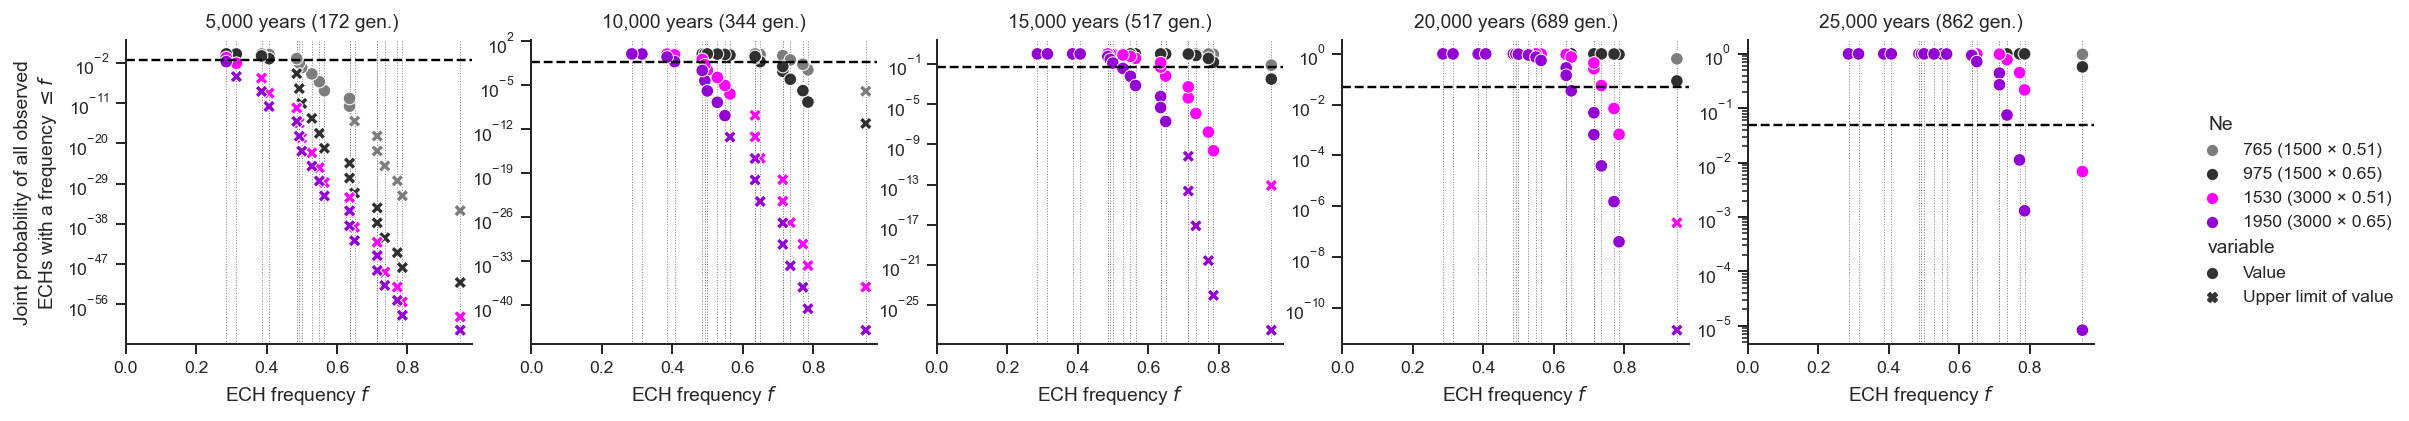

In [ ]:
plot_df = df.rename(columns={'joint_prob': 'Value', 'limit_joint_prob': 'Upper limit of value'})

plot_df.loc[plot_df['length'] == 500000.0, 'length'] = '500kb'
plot_df.loc[plot_df['length'] == 1000000.0, 'length'] = '1Mb'

plot_df = plot_df.melt(id_vars=['haploid_N', 'freq', 'max_gens', 'length', 'rec'], value_vars=['Value', 'Upper limit of value'])
plot_df['Ne'] = (plot_df.haploid_N / 2).astype('int')

plot_df = plot_df.loc[
    #(plot_df.Ne.isin([1950, 975])) & \
    # (plot_df.rec == 1.16e-8) & \
    (plot_df.rec == 0.77e-8) & \
    (plot_df.length == '500kb')]

# plot_df['Ne'] = plot_df['Ne'].cat.remove_unused_categories()
# plot_df['re'] = plot_df['Ne'].cat.remove_unused_categories()

plot_df.loc[plot_df['Ne'] == 1950, 'Ne'] = '1950 (3000 × 0.65)'
plot_df.loc[plot_df['Ne'] == 1530, 'Ne'] = '1530 (3000 × 0.51)'
plot_df.loc[plot_df['Ne'] == 975, 'Ne'] = '975 (1500 × 0.65)'
plot_df.loc[plot_df['Ne'] == 765, 'Ne'] = '765 (1500 × 0.51)'

plot_df.loc[plot_df['max_gens'] == 172, 'max_gens'] = ' 5,000 years (172 gen.)'
plot_df.loc[plot_df['max_gens'] == 344, 'max_gens'] = '10,000 years (344 gen.)'
plot_df.loc[plot_df['max_gens'] == 517, 'max_gens'] = '15,000 years (517 gen.)'
plot_df.loc[plot_df['max_gens'] == 689, 'max_gens'] = '20,000 years (689 gen.)'
plot_df.loc[plot_df['max_gens'] == 862, 'max_gens'] = '25,000 years (862 gen.)'

hue_order=['765 (1500 × 0.51)', '975 (1500 × 0.65)', '1530 (3000 × 0.51)', '1950 (3000 × 0.65)']

plot_df = plot_df.sort_values('Ne', key=np.vectorize(hue_order.index))

with sns.plotting_context('paper'):
    with sns.axes_style('ticks'):
        with sns.color_palette(["#7D7D7D", "#303030", "#FF01FF", "#9300D3"]):

            g = sns.relplot(data=plot_df,
                            x='freq', y='value', #col_wrap=True, #row='rec', 
                            col='max_gens', hue='Ne',  
                            kind='scatter', style='variable',hue_order=hue_order, 
                            col_order = pd.Series(plot_df.max_gens.unique()).sort_values(), 
                              height=3, aspect=1,
                            legend="full",    
                            s=40,
                            facet_kws=dict(sharex=True, sharey=False, margin_titles=True),
#                            gridspec_kws=dict(hspace=10),
                             )            

        for ax in g.axes.flat:
            for freq in extended_peak_regions_90.prop_swept:
                ax.axvline(freq, zorder=0, color='grey', linestyle='dotted', linewidth=0.5)
            plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
            g.set_titles(row_template = '', col_template = '{col_name}')

        for (i, ax) in enumerate(g.axes.flat):
            ax.set_xlabel(r'ECH frequency $f$') # need to set labels manually because the names of facet function are start and end.
            if i == 0:
                ax.set_ylabel('Joint probability of all observed\n' + r'ECHs with a frequency $\leq f$')
            plt.setp(ax.texts, rotation="0") # remove the original texts, important to do this before setting titles
            ax.axhline(0.05, linestyle="dashed", color="black")

            ####
            ax.set_xlim(left=0)
            ax.set_yscale('log')
            ####
            
        plt.xlim(left=0)
        plt.yscale('log')
        # plt.ylim(1e-4, 1.5)

        
        plt.savefig(figures_dir / 'multinom_sims_joint_global_cellgen_revision.pdf', bbox_inches='tight')
        plt.savefig(figures_dir / 'multinom_sims_joint_global_cellgen_revision.png', bbox_inches='tight')        

In [39]:
plot_df.loc[(plot_df.Ne == '765 (1500 × 0.51)') & (plot_df.max_gens.str.startswith('15,000 years'))]

,haploid_N,freq,max_gens,length,rec,variable,value,Ne
418,1530,0.285714,"15,000 years (517 gen.)",500kb,7.700000e-09,Upper limit of value,NaN,765 (1500 × 0.51)
419,1530,0.314286,"15,000 years (517 gen.)",500kb,7.700000e-09,Upper limit of value,NaN,765 (1500 × 0.51)
420,1530,0.385714,"15,000 years (517 gen.)",500kb,7.700000e-09,Upper limit of value,NaN,765 (1500 × 0.51)
421,1530,0.407143,"15,000 years (517 gen.)",500kb,7.700000e-09,Upper limit of value,NaN,765 (1500 × 0.51)
422,1530,0.485714,"15,000 years (517 gen.)",500kb,7.700000e-09,Upper limit of value,NaN,765 (1500 × 0.51)
424,1530,0.500000,"15,000 years (517 gen.)",500kb,7.700000e-09,Upper limit of value,NaN,765 (1500 × 0.51)
423,1530,0.492857,"15,000 years (517 gen.)",500kb,7.700000e-09,Upper limit of value,NaN,765 (1500 × 0.51)
425,1530,0.528571,"15,000 years (517 gen.)",500kb,7.700000e-09,Upper limit of value,NaN,765 (1500 × 0.51)
426,1530,0.550000,"15,000 years (517 gen.)",500kb,7.700000e-09,Upper limit of value,NaN,765 (1500 × 0.51)
427,1530,0.564286,"15,000 years (517 gen.)",500kb,7.700000e-09,Upper limit of value,NaN,765 (1500 × 0.51)


Min, Max span of time for sweeps to have occured:

In [29]:
(9599 - 2*2871) * 28/29, (9599 + 2*2871) *28/29

(3724.0, 14812.0)

## Pool-Nielsen effect

In [ ]:
class MidpointNormalize(matplotlib.colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work
    there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y), numpy.isnan(value))

Population size reduction

In [ ]:
50000 / 29

In [ ]:
h = 0.75
N = 2e4
g = numpy.arange(0, 5e3)
f = 1 / numpy.arange(1, 500)

def reduction(g, f):
    return (2*N*h * (f - (f - 1) * numpy.exp(-g/(2*N*h*f)))) / \
           (2*N *   (f - (f - 1) * numpy.exp(-g/(2*N*  f)))) 

gg, ff = numpy.meshgrid(g, f, sparse=True)
z = reduction(gg, ff)

with sns.axes_style('white'):
    levels=numpy.arange(0, 1.1, 0.1)
    plt.contourf(g, 1/f, z, cmap="RdBu", levels=levels, norm=MidpointNormalize(midpoint=0.75,vmin=0.25, vmax=1))
    CS = plt.contour(g, 1/f, z, colors='k', linewidths=1, levels=levels)
    plt.clabel(CS, CS.levels, fmt='%.2f', fontsize=8)
    plt.ylabel("Fold reduction")
    plt.xlabel("Generations since reduction")

Population size increase:

In [ ]:
h = 0.75
N = 2e4
g = numpy.arange(0, 5e5, 100)
f = numpy.arange(1, 100)

def increase(g, f):
    return (2*N*h * (f - (f - 1) * numpy.exp(-g/(2*N*h*f)))) / \
           (2*N *   (f - (f - 1) * numpy.exp(-g/(2*N*  f)))) 

gg, ff = numpy.meshgrid(g, f, sparse=True)
z = reduction(gg, ff)

with sns.axes_style('white'):
    levels=numpy.arange(0, 1.1, 0.05)
    plt.contourf(g, f, z, cmap="RdBu", levels=levels, norm=MidpointNormalize(midpoint=0.75,vmin=0.25, vmax=1))
    CS = plt.contour(g, f, z, colors='k', linewidths=1, levels=levels)
    plt.clabel(CS, CS.levels, fmt='%.2f', fontsize=8)
    plt.ylabel("Fold increase")
    plt.xlabel("Generations since reduction")

Bottleneck

In [ ]:
h = 0.6
N = 1e4
#f = 1 / np.arange(1, 500)
f = 1 / numpy.arange(1, 20)

bottle_len = 2413
bottle_end = numpy.arange(0, 4000)
g1 = bottle_end
g2 = bottle_len

def bottleneck(g1, f):
    return (2*N*h * (numpy.exp(-(f*g1+g2)/(2*N*h*f)) * \
                      (1 - f + numpy.exp(g2/(2*N*h*f)) * (f - 1 + numpy.exp(g1/(2*N*h)))))) / \
           (2*N*1 * (numpy.exp(-(f*g1+g2)/(2*N*1*f)) * \
                      (1 - f + numpy.exp(g2/(2*N*1*f)) * (f - 1 + numpy.exp(g1/(2*N*1))))))

gg, ff = numpy.meshgrid(g1, f, sparse=True)
z = bottleneck(gg, ff)

with sns.axes_style('white'):
    levels=numpy.arange(0, 1.1, 0.05)
    plt.contourf(g1, 1/f, z, cmap="RdBu", levels=levels, norm=MidpointNormalize(midpoint=0.75,vmin=0.25, vmax=1))
    CS = plt.contour(g1, 1/f, z, colors='k', linewidths=1, levels=levels)
    plt.clabel(CS, CS.levels, fmt='%.2f', fontsize=8)
    plt.ylabel("Fold reduction in bottleneck")
    plt.xlabel("Generations since end of bottleneck")

    plt.axhline(5, linestyle='dashed', color='black') 
    plt.axvline(1034, linestyle='dashed', color='black') # 30000 start of bottle

#    plt.savefig(str(figures_dir / 'pool_nielsen_bottleneck.pdf'))


In [ ]:
h = 0.5
N = 1e4
#f = 1 / np.arange(1, 500)
f = 1 / numpy.arange(1, 20)

bottle_len = 2413 # 70000
bottle_end = numpy.arange(0, 4000)
g1 = bottle_end
g2 = bottle_len

def bottleneck(g1, f):
    return (2*N*h * (numpy.exp(-(f*g1+g2)/(2*N*h*f)) * \
                      (1 - f + numpy.exp(g2/(2*N*h*f)) * (f - 1 + numpy.exp(g1/(2*N*h)))))) / \
           (2*N*1 * (numpy.exp(-(f*g1+g2)/(2*N*1*f)) * \
                      (1 - f + numpy.exp(g2/(2*N*1*f)) * (f - 1 + numpy.exp(g1/(2*N*1))))))

gg, ff = numpy.meshgrid(g1, f, sparse=True)
z = bottleneck(gg, ff)

with sns.axes_style('white'):
    levels=numpy.arange(0, 1.1, 0.05)
    plt.contourf(g1, 1/f, z, cmap="RdBu", levels=levels, norm=MidpointNormalize(midpoint=0.75,vmin=0.25, vmax=1))
    CS = plt.contour(g1, 1/f, z, colors='k', linewidths=1, levels=levels)
    plt.clabel(CS, CS.levels, fmt='%.2f', fontsize=8)
    plt.ylabel("Fold reduction in bottleneck")
    plt.xlabel("Generations since end of bottleneck")
    
#    plt.savefig(str(figures_dir / 'pool_nielsen_bottleneck.pdf'))

    plt.axhline(5, linestyle='dashed', color='black') 
    plt.axvline(1034, linestyle='dashed', color='black') # 30000 start of bottle


In [ ]:
import numpy as np

def exp_coal(g, N):
    return 2*N - (g * np.exp(-g/(2*N))) / (1 - np.exp(-g/(2*N)))

expectation = 0
g_prev = None
for g, N in pairs:
    if g_prev is None:
        expectation += exp_coal(g, N)
    else:
        np.exp(-g_prev/(2*N_prev)) * (prev_g + exp_coal(g, N))                  
    t_prev, N_prev = t, N
